Code implementation based on lab 1 and lab 6

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook

In [97]:
socket_rates = np.array([4,8,6,12]) #Rates of socket
samples = 100000
arms = 4

### a.

In [100]:
#Simple implementation of a bandit problem with 4 arms

class SimpleBandit:
    
    def __init__(self, k_arm=4, indices=[1,2,3,4], true_reward=[]):
        self.k = k_arm
        self.indices = indices  # Indices for actions. Used to select a specific arm (action).
        self.true_reward = true_reward #mean reward of each socket
        
    def getRates(self):
        return self.true_reward

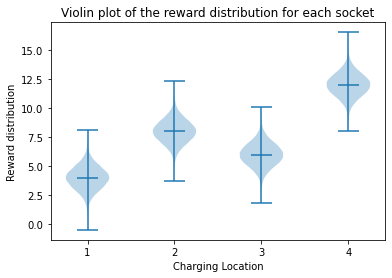

In [104]:
# Plot a reward distribution
plt.violinplot(dataset=np.random.randn(samples, arms) + SimpleBandit(true_reward=socket_rates).getRates(), showmeans=True)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,3,4])
plt.title('Violin plot of the reward distribution for each socket')
plt.xlabel("Charging Location")
plt.ylabel("Reward distribution")
plt.show()

In [73]:
# Implementation of a bandit environment to be put into a Monte Carlo Control for training


class BanditEnviroment:
    
    def __init__(self, k_arm=4, epsilon=0., initial=0., tempering=None, indices=[1,2,3,4], UCB_param=None, true_reward=[]):
        # Initialise the input variables
        self.k = k_arm
        self.indices = indices  # Indices for actions. Used to select a specific arm (action).
        self.time = 0
        self.UCB_param = UCB_param
        self.tempering = tempering
        self.average_reward = 0
        self.true_reward = true_reward #mean reward of each socket
        self.epsilon = epsilon
        self.initial = initial
        self.reset()
        
    def reset(self):
        # real reward for each action
        self.q_true = self.true_reward
  
        # estimation for each action
        self.q_estimation = np.zeros(self.k)
  
        # # of chosen times for each action
        self.action_count = np.zeros(self.k)
          
        # record the best action for comparison between implementing policy and optimal policy    
        self.best_action = np.argmax(self.true_reward)
  
        self.time = 0
        
    # Determine what the action will be for this bandit
    def act(self, timestep):
        
        #Tempering epsilon strategy
        if self.tempering is not None:
            # Decrement epsilon with respect to increase in timestep
            self.epsilon = max(0,1-self.tempering*self.time/timestep)
            
        if np.random.rand() < self.epsilon:
            # Return a random selection from one of the actions (index of the action)
            return (np.random.choice(self.indices) - 1)
        
        # UCB Strategy
        if self.UCB_param is not None:
            # Fill out the UCB estimation
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
              
            # Set q_best to max UCB estimate
            q_best = np.max(UCB_estimation)
              
            # Return the best UCB estimate action (index). If a tie select randomly. Act greedily.
            return np.random.choice(np.where(UCB_estimation == q_best)[0])
  
        # Act greedily and select max q_estimate
        q_best = np.max(self.q_estimation)
  
        # Return action(index) of max q_estimate. If a tie select randomly. Act greedily.
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

        
    # Take an action, update the estimates with this action. Return reward obtained.
    def step(self, action):
        # Generate a reward under normal distribution N with mean real_reward and std of 1. N(real_reward,1)
        reward = np.random.randn() + self.q_true[action]
        # Increment timestep
        self.time += 1
        # Increment action selection count N_t(a)
        self.action_count[action] += 1
        # Update average reward for the bandit.
        self.average_reward += (reward - self.average_reward) / self.time
        
        return reward

    def update(self, action, reward):
        # update estimation using sample averages where alpha changes every timestep as 1/N(a)
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]


In [72]:
#Monte carlo control implementation
# @env: environment to run Monte Carlo Control on
# @timestep: total number of timesteps per run
# @policy: record the best policy chosen by the agent after training

class MonteCarlo:

    def __init__(self, env, timestep=1000):
        self.env = env
        self.timestep = timestep

        self.action_values = None
        self.action_counts = None
        self.policy = None
        self.reset()

    def reset(self):
        self.action_values = self.env.indices
        self.action_counts = np.zeros(self.env.k)
        self.policy = -1
    
        self.rewards = np.zeros(self.timestep)
        self.best_action_counts = np.zeros(self.timestep)
    
    # Play an episode
    def play_episode(self, explore=True):
        rewarded = np.zeros(self.timestep)
        best_action_counts = np.zeros(self.timestep)
        while self.env.time < self.timestep:
            if explore:
                # Explore for training
                action = self.explore(self.timestep)
            else:
                action = self.policy
            
            #Return reward for the current timestep
            reward = self.step(action)
            
            #Update estimated rewards for the action chosen
            self.update(action, reward)
            
            self.policy = np.argmax(self.env.q_estimation)
    
            #Update statistics
            rewarded[self.env.time-1] = reward #record rewards
            if action == self.env.best_action:
                best_action_counts[self.env.time-1] = 1 #record best action selected
    
        return (rewarded, best_action_counts, self.policy)

  
    # Select a action to perform
    def explore(self, timestep):
        return self.env.act(self.timestep)
    
    def step(self, action):
        return self.env.step(action)
  
    def update(self, action, reward):
        self.env.update(action, reward)
    

In [68]:
# Simulation for 2000 runs of Monte Carlo Control
# @runs: Number of runs to simulate
# @time: Total number of timesteps per run
# @bandits: List of objects of type bandit specifying hyperparameters for each bandit to simulate
def simulate(runs, time, bandits):
    # Initialise rewards and best action counts for analysis later
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    # iterate through bandits
    for i, bandit in enumerate(bandits):
        mc = MonteCarlo(env=bandit, timestep=time)
        for r in tnrange(runs, desc='bandit: '+ str(i)):
            bandit.reset()
            mc.reset()
            reward, best_action_count, policy = mc.play_episode()

            rewards[i,r] = reward
            best_action_counts[i,r] = best_action_count     

    # Data analysis
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    
    q_star = np.array([np.max(bandit.q_true) for bandit in bandits])
    T_qstar = time * np.ones((len(bandits), runs)) * q_star[:, np.newaxis]
    
    
    #Calculate regret (rho) Tq* - sum_t=1 ^T q(a_t)
    # Find what are the optimal reward (q*) for each bandit. Compute sum of rewards and subract from T_qstar
    regret = T_qstar - np.sum(rewards, axis=2)
    mean_regret = regret.mean(axis=1)
    return mean_best_action_counts, mean_rewards, mean_regret

### c.

In [69]:
# Plots of different epsilon greedy values.

def epsilon_greedy_avg_reward_plot(runs=2000, time=1000):
    epsilons = [0.1]
    bandits = [BanditEnviroment(k_arm=4, epsilon=eps, true_reward=socket_rates) for eps in epsilons]
    best_action_counts, rewards, regrets = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(3, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
        plt.xlabel('steps')
        plt.ylabel('average reward')
        plt.legend()

    plt.subplot(3, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
        plt.xlabel('steps')
        plt.ylabel('% optimal action')
        plt.legend()
        
    print("Regret:")
    for eps, regret in zip(epsilons, regrets):
        print('epsilon = %.02f' % (eps), 'regret = %.02f' % regret)

<ipython-input-68-f1544703793c>:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for r in tnrange(runs, desc='bandit: '+ str(i)):



Regret:
epsilon = 0.10 regret = 590.22


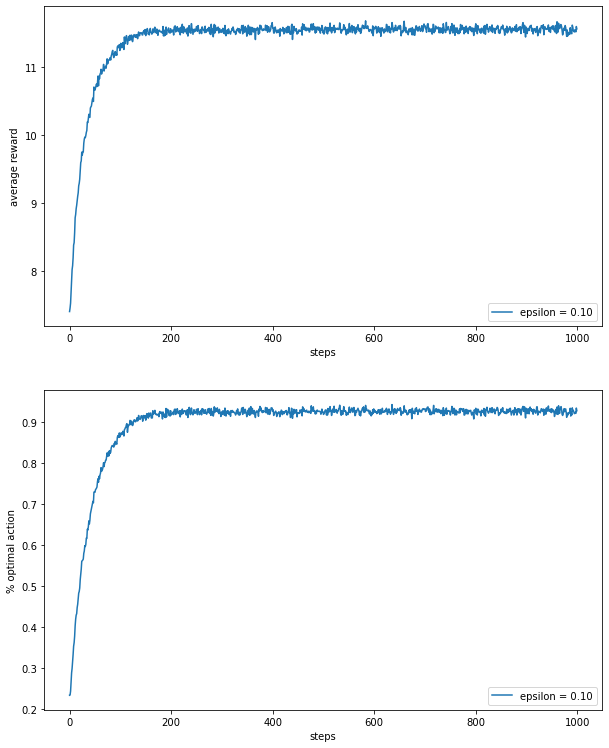

In [70]:
epsilon_greedy_avg_reward_plot()

### d.

In [93]:
# Plots of tempering epsilon-greedy exploration with different tempering parameters

def tempering_epsilon_greedy_avg_reward_plot(runs=2000, time=1000):
    tempering = [2, 5, 20, 30]
    bandits = [BanditEnviroment(k_arm=4, epsilon=0.1, true_reward=socket_rates, tempering = temper) for temper in tempering]
    best_action_counts, rewards, regrets = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(3, 1, 1)
    for temper, reward in zip(tempering, rewards):
        plt.plot(reward, label='explore = %.02f' % (temper))
        plt.xlabel('steps')
        plt.ylabel('average reward')
        plt.legend()

    plt.subplot(3, 1, 2)
    for temper, counts in zip(tempering, best_action_counts):
        plt.plot(counts, label='explore = %.02f' % (temper))
        plt.xlabel('steps')
        plt.ylabel('% optimal action')
        plt.legend()
        
    print("Regret:")
    for temper, regret in zip(tempering, regrets):
        print('explore = %.02f' % (temper), 'regret = %.02f' % regret)

<ipython-input-68-f1544703793c>:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for r in tnrange(runs, desc='bandit: '+ str(i)):



Regret:
explore = 2.00 regret = 1125.47
explore = 5.00 regret = 452.17
explore = 20.00 regret = 117.81
explore = 30.00 regret = 118.14


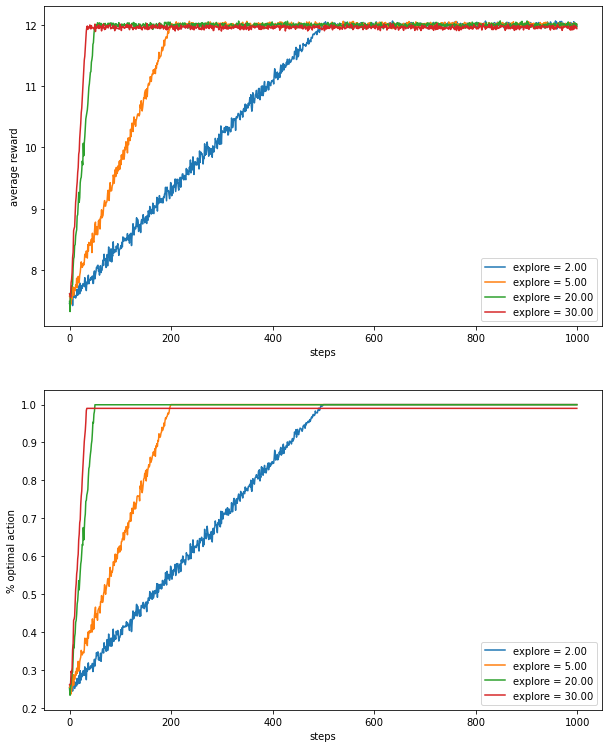

In [94]:
tempering_epsilon_greedy_avg_reward_plot()

### e.

In [111]:
# UCB degree of exploration 1 compared to epsilon-greedy 0.1

def upper_confidence_boundary_plot(runs=2000, time=1000):
    bandits = []
    bandits.append(BanditEnviroment(epsilon=0, UCB_param=1, true_reward=socket_rates))
    bandits.append(BanditEnviroment(epsilon=0.1, true_reward=socket_rates))
    _, average_rewards, _ = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 10))
    plt.plot(average_rewards[0], label='UCB c = 1')
    plt.plot(average_rewards[1], label='epsilon greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.show()

<ipython-input-68-f1544703793c>:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for r in tnrange(runs, desc='bandit: '+ str(i)):


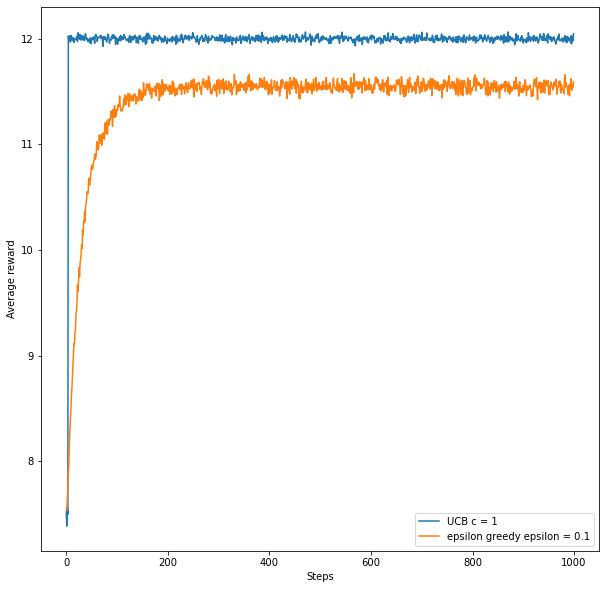

In [113]:
upper_confidence_boundary_plot()

### f.

In [116]:
#Different degree of exploration try and plot

def different_exploration_upper_confidence_boundary_plot(runs=2000, time=1000):
    exploration = [0.1, 1, 2, 5, 20]
    bandits = [BanditEnviroment(k_arm=4, epsilon=0, UCB_param=explore, true_reward=socket_rates) for explore in exploration]
    best_action_counts, rewards, regrets = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(3, 1, 1)
    for explore, reward in zip(exploration, rewards):
        plt.plot(reward, label='explore = %.02f' % (explore))
        plt.xlabel('steps')
        plt.ylabel('average reward')
        plt.legend()

    plt.subplot(3, 1, 2)
    for explore, counts in zip(exploration, best_action_counts):
        plt.plot(counts, label='explore = %.02f' % (explore))
        plt.xlabel('steps')
        plt.ylabel('% optimal action')
        plt.legend()
        
    print("Regret:")
    for explore, regret in zip(exploration, regrets):
        print('explore = %.02f' % (explore), 'regret = %.02f' % regret)

<ipython-input-68-f1544703793c>:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for r in tnrange(runs, desc='bandit: '+ str(i)):



Regret:
explore = 0.10 regret = 17.46
explore = 1.00 regret = 19.45
explore = 2.00 regret = 24.05
explore = 5.00 regret = 90.24
explore = 20.00 regret = 836.54


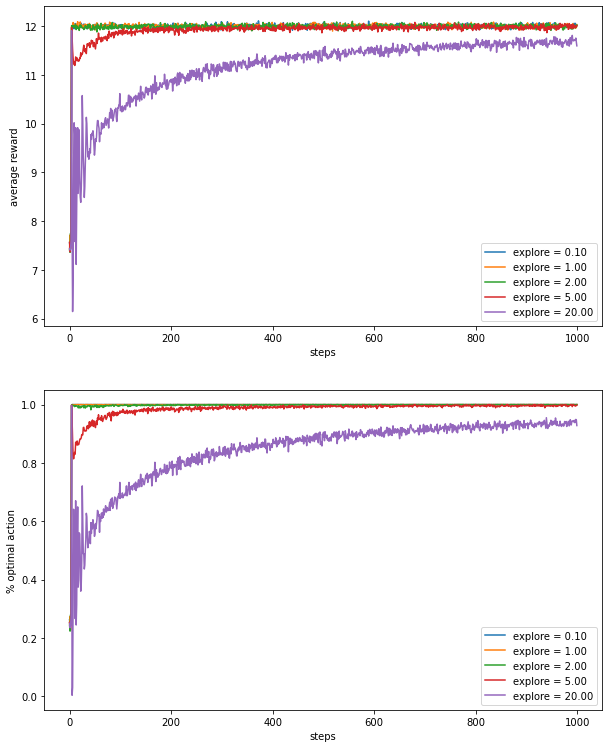

In [118]:
different_exploration_upper_confidence_boundary_plot(runs=1000)